# AQI During the California, Thomas Fire (2017-18)
__Author:__ Briana Barajas

__Github repository:__ [link here]('https://github.com/briana-barajas/thomas-fire-aqi')

## Background
The Thomas Fire began late December (2017) in Ventura County and continued to affect both Santa Barbara and Ventura counties into the new year. This analysis uses raster data to produce a map of the fire's perimeter. Additionally, a simple visualization was created to demonstrated the severity of the Thomas Fire's affect on air quality (AQI) in both counties.

## About Data

### Raster Data
This dataset, from the Landsat Collection 2 Level-2, contains red, green, near-infrared, and shortwave infrared layers. The data was originally collected by the Landsat 8 satellite, and was corrected for surface reflectance and simplified. 

__Useful Links:__
* [Band designations for Landsat satellites]('https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites')
* [Common Landsat band combos]('https://www.usgs.gov/media/images/common-landsat-band-combinations')
* [Scale factor with Landsat Level-2 science products]('https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products')
* [Final proccess collection from Microsoft Planetary Computer]('https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2')


### Fire Perimeter Data
CAL Fire provides annual geographic data on fire perimeters. The fire started December 4th, 2017 and was contained by January 12th, 2018. Since the majority of fire growth was in 2017, this analysis will use only the 2017 data.

__Useful Links:__ 
[Fire perimeter]('https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about')

### Air Quality Data
The Air Quality Data can be pulled from the U.S. Environmental Protection Agency (EPA). This dataset provides air quality data from counties throughout the United States and can be filtered to examine Santa Barbara County during the duration of the Thomas Fire.

__Useful Links:__ 
[Air quality]('https://www.epa.gov/air-trends/air-quality-cities-and-counties')

### County Perimeter Data
California provides shapefiles on all counties within the state.

__Useful Links:__
[County perimeters]('https://data.ca.gov/dataset/ca-geographic-boundaries')

## Libraries and Functions
Loading necessary libraries and functions:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 

import xarray as xr
import rioxarray as rioxr
import geopandas as gpd
import contextily as cx

## Loading Data
The Landsat raster data and fire perimeter data are stored in a folder and accessed directly. The AQI data can be accessed using the link.

Loading data for analysis:

In [2]:
# raster data
landsat_raw = rioxr.open_rasterio(os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc'))

# ca fire perimeter data
fire_perimeter = gpd.read_file(os.path.join(os.getcwd(), 'data', 'fire_perim',
                                           'California_Fire_Perimeters_2017.shp'))
#import 2017 and 2018 aqi data 
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')

## Data Cleaning for Visualization
### Raster Data
The raster data contains additional bands that are not needed for this analysis, which will utilize the short-wave infrared (swir22), near infrared (nir08), and red bands. Removing the bands and coordinates which are not needed will improve processing in the following steps. 

In [3]:
# remove extra dims and coords
landsat = landsat_raw.squeeze().drop('band')

### Fire Perimeter Data
As mentioned in the, "About Data" section, the fire perimeter data is for the entire state of California. The data was filtered to the fire of interest, and the coordinate reference system (CRS) was updated for mapping purposes.

In [4]:
# lowercase col names
fire_perimeter.columns = fire_perimeter.columns.str.lower()

# update CRS to match landsat data
fire_perimeter = fire_perimeter.to_crs(landsat.rio.crs)

# filter to fire of interest
thomas = fire_perimeter[fire_perimeter['fire_name']=='THOMAS']

## Mapping Affected Counties
Both Ventura and Santa Barbara counties were impacted by the 2017 Thomas Fire. The following map shows the extent of both counties

In [5]:
ca_counties = gpd.read_file(os.path.join(os.getcwd(), 'data', 'county-lines','CA_Counties_TIGER2016.shp'))
impacted_counties = ca_counties[(ca_counties.NAME == 'Ventura') | (ca_counties.NAME == 'Santa Barbara')]

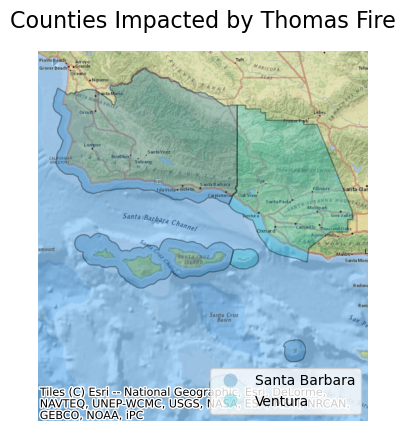

In [6]:
fig, ax = plt.subplots() #create figure

impacted_counties.to_crs(epsg=3857).plot(ax = ax, figsize = (5,5), alpha = 0.3,
                                        column = 'NAME', edgecolor='k',
                                        legend = True,
                                         legend_kwds={'loc': 'lower right'})

cx.add_basemap(ax, source=cx.providers.Esri.NatGeoWorldMap)

# update title and axes
ax.set_title("Counties Impacted by Thomas Fire", fontdict={"fontsize": "16"})
ax.set_axis_off()
plt.savefig('images/impacted-counties.png')

## Mapping the Fire Perimeter
The cleaned and filtered data can be used to produce a false color image depicting the extent of the Thomas Fire's perimeter:

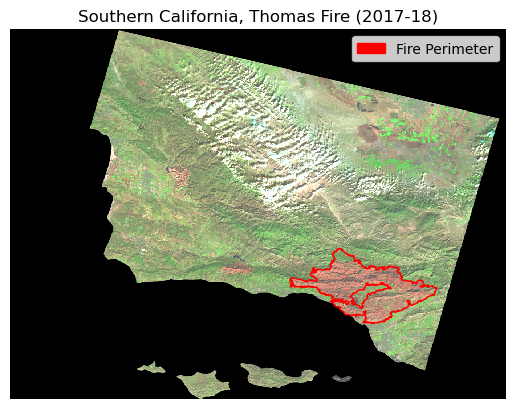

In [7]:
fig, ax = plt.subplots()
ax.axis('off')

# map thomas fire perimeter
thomas.plot(ax=ax, color = 'None', edgecolor = 'red', legend=True)
thomas_patch = mpatches.Patch(color = 'red', label = 'Fire Perimeter') #legend parameters

# map raster data
landsat[['swir22','nir08','red']].to_array().plot.imshow(robust=True) #plot SB county 

# update legend and title
ax.set_title('Southern California, Thomas Fire (2017-18)')
_ = ax.legend(handles=[thomas_patch])
plt.savefig('images/false-color-image.png')

## Analyzing Impact on AQI
The Thomas Fire burned 281,893 acres, affecting both Santa Barbara and Ventura Counties. The map above shows the perimeter of the fire, but doesn't give much more information on the impact. The following analysis looks at air quality (AQI) in Ventura and Santa Barbara county from 2017 to 2018.

### Data Cleaning for AQI
Air quality data is provided for all counties and states within the U.S., therefore filtering is required in addition to data tidying to create subsets of the counties of interest. Additional tidying steps on the date column will be useful for plotting the data.

In [8]:
# combine 2017-18 AQI data
aqi = pd.concat([aqi_17, aqi_18])

# clean col names
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

# SB and VC county subset
aqi_sb = aqi.loc[aqi['county_name']=='Santa Barbara',
       ['date','aqi','category','defining_parameter', 'defining_site','number_of_sites_reporting']]

aqi_vc = aqi.loc[aqi['county_name']=='Ventura',
       ['date','aqi','category','defining_parameter', 'defining_site','number_of_sites_reporting']]

# change date col to data time object
aqi_sb.date = pd.to_datetime(aqi_sb.date)
aqi_vc.date = pd.to_datetime(aqi_vc.date)

# set date column as index
aqi_sb = aqi_sb.set_index('date')
aqi_vc = aqi_vc.set_index('date')

# add column w/5-day rolling average
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()
aqi_vc['five_day_average'] = aqi_vc.aqi.rolling('5D').mean()

## Plot: AQI From 2017-2018
The following plots show air quality in Santa Barbara and Ventura counties, which were both impacted by the Thomas Fire. In addition to the daily aqi (blue), there is a 5-day rolling average that demonstrates the mean AQI over 5-days.

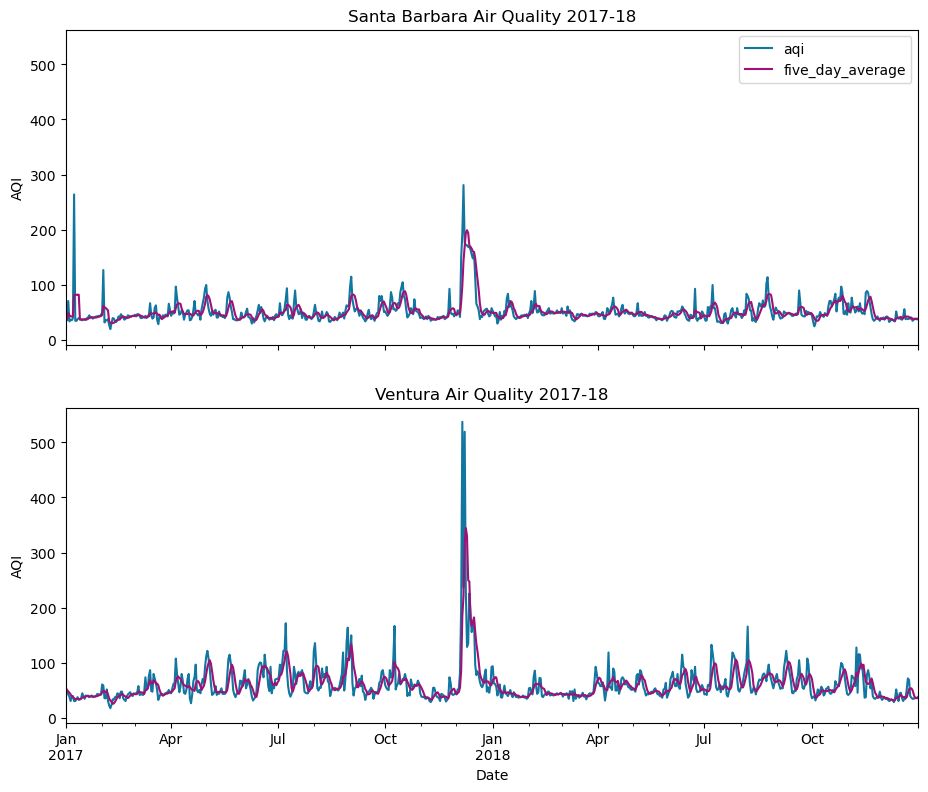

In [9]:
fig, [ax1, ax2] = plt.subplots(ncols=1, nrows=2,
                               sharex = True, sharey=True,
                              figsize = (11,9))

aqi_sb.aqi.plot(ax = ax1, color = '#1177A0', legend = True)  
aqi_sb.five_day_average.plot(ax=ax1, color = '#A01177', 
                            title = 'Santa Barbara Air Quality 2017-18', 
                            legend = True, 
                             xlabel = "Date", 
                             ylabel = "AQI") 

aqi_vc.aqi.plot(ax = ax2, color = '#1177A0', legend = False)  
_ = aqi_vc.five_day_average.plot(ax=ax2, color = '#A01177', 
                            title = 'Ventura Air Quality 2017-18',
                            legend = False, 
                             xlabel = "Date",
                             ylabel = "AQI")
plt.savefig('images/aqi-plot.png')

## References
California Open Data Portal (2016), CA Geographic Boundaries [Data File] Available from: https://data.ca.gov/dataset/ca-geographic-boundaries. Access date: December 13, 2023.

California State Geoportal. (2023, August 7), California Fire Perimeters (all) [Data file] Available from: https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about. Access date: November 28, 2023.

Earth Resources Observation And Science (EROS) Center. Collection-2 Landsat 8-9 OLI (Operational Land Imager) and TIRS (Thermal Infrared Sensor) Level-2 Science Products. U.S. Geological Survey, 2013, doi:10.5066/P9OGBGM6.

Environmental Protection Agency (EPA). (2023, November 9), Air Data: Air Quality Data Collected at Outdoor Monitors Across the US. Pre-Generated Data Files [URL] Available from: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. Access date: November 28, 2023.

“Thomas Fire.” _Wikipedia_, Wikimedia Foundation, 9 Nov. 2023, en.wikipedia.org/wiki/Thomas_Fire. Accessed 28 Nov. 2023.
